# Isolation Forest 異常偵測教學

Isolation Forest 是一種基於樹模型的異常偵測方法，適合用於高維度資料。

本教學將由淺入深，帶你了解 Isolation Forest 的原理、視覺化範例，並以實際詐欺資料集進行應用與解釋。

**目標：**
- 了解 Isolation Forest 的基本概念
- 以 toy data 視覺化異常偵測流程
- 實際應用於詐欺資料集
- 以 SHAP 解釋模型結果

---

## 1. Isolation Forest 原理簡介

### 1.1 核心概念

Isolation Forest（孤立森林）是一種專門設計用於異常偵測的算法，它的核心思想是：**異常點比正常點更容易被「孤立」**。

**為什麼異常點容易被孤立？**
- 正常數據點通常聚集在一起，形成高密度區域
- 異常點通常分散且遠離正常數據群體
- 當我們隨機切割數據空間時，異常點需要更少的切割次數就能被隔離

### 1.2 算法基本原理

Isolation Forest 採用類似隨機森林的方法，但有關鍵不同：

**隨機森林 vs Isolation Forest：**
- **隨機森林**：根據信息增益或基尼指數選擇最佳分割點
- **Isolation Forest**：完全隨機選擇特徵和分割點

**工作流程：**
1. **隨機選擇特徵**：從所有特徵中隨機選一個
2. **隨機選擇分割值**：在該特徵的最大值和最小值之間隨機選擇
3. **遞歸分割**：重複步驟1-2，直到每個子空間只有一個數據點
4. **計算路徑長度**：記錄每個點從根節點到葉節點的路徑長度
5. **異常分數計算**：路徑越短，越可能是異常點

### 1.3 數學原理

對於 n 個樣本構建的 iTree，異常分數計算公式：

$$S(x,n) = 2^{-\frac{E(h(x))}{c(n)}}$$

其中：
- $E(h(x))$ 是樣本 x 在所有樹中的平均路徑長度
- $c(n) = 2H(n-1) - \frac{2(n-1)}{n}$ 是 n 個樣本的平均路徑長度
- $H$ 是調和函數

**異常分數解讀：**
- **接近 1**：高異常可能性
- **接近 0**：正常點可能性高  
- **接近 0.5**：整個數據集無明顯異常值

---

## 2. Isolation Forest 算法詳解

### 2.1 iTree（隔離樹）的構建過程

每棵隔離樹的構建過程如下：

**步驟 1：採樣**
- 從 N 個訓練樣本中隨機抽取 ψ 個樣本（通常 ψ << N）
- 研究表明當 ψ > 256 時效果提升不大，且會增加計算成本

**步驟 2：遞歸分割**
1. 隨機選擇一個特徵 (attribute)
2. 在該特徵的 [min_value, max_value] 範圍內隨機選擇分割點
3. 將數據分為兩部分：< 分割點的放左子樹，≥ 分割點的放右子樹
4. 對左右子樹重複此過程

**終止條件：**
- 節點只包含一個樣本
- 達到預設的最大樹深度
- 節點中所有樣本完全相同

### 2.2 為什麼小樣本效果更好？

![採樣效果示意圖](assets/iforest-original-vs-sub-sample.png)

**原因分析：**
- **採樣前**：正常樣本和異常樣本可能重疊，難以分離
- **採樣後**：異常樣本和正常樣本能明顯分開
- **小樣本優勢**：減少正常數據的干擾，突出異常模式

### 2.3 算法優勢與限制

**主要優勢：**
- ✅ **線性時間複雜度**：適合大數據集
- ✅ **無監督學習**：不需要標記數據
- ✅ **可並行化**：每棵樹獨立構建
- ✅ **內存效率高**：只需要少量樣本

**主要限制：**
- ❌ **高維度問題**：隨機選擇特徵可能忽略重要維度
- ❌ **局部異常**：主要檢測全局異常，對局部異常不敏感
- ❌ **異常比例敏感**：如果異常比例過高會影響效果

---

## 3. 簡單範例：toy data 異常偵測與視覺化

我們先用 2D toy data 來示範 Isolation Forest 如何分辨正常與異常點。

### 3.1 數據生成與視覺化

首先生成包含正常點和異常點的合成數據集：

正常數據點數量: 200
異常數據點數量: 20
總數據點數量: 220
實際異常比例: 9.09%


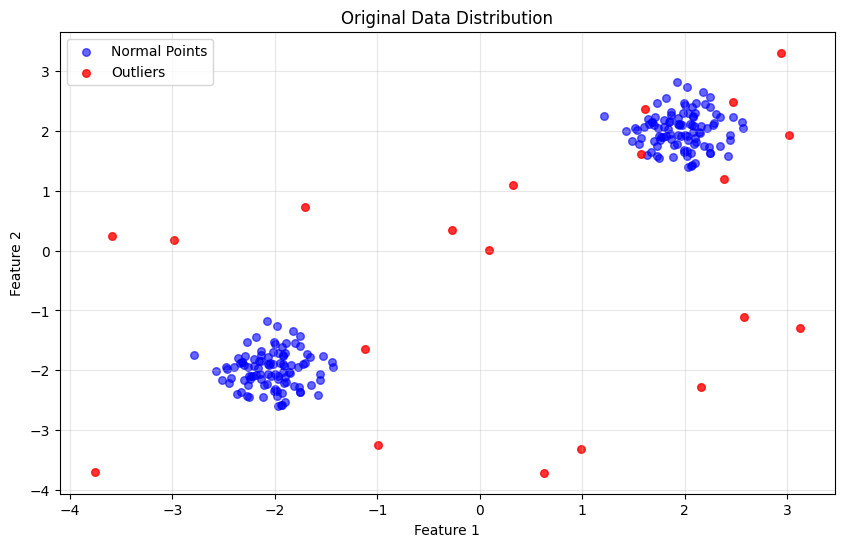

In [23]:
# 載入所需函式庫
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 設定隨機種子確保結果可重現
rng = np.random.RandomState(42)

# 生成正常數據點
# 創建兩群正常數據，每群100個點
X_normal = 0.3 * rng.randn(100, 2)  # 標準差0.3讓數據更集中
X = np.r_[X_normal + 2, X_normal - 2]  # 分別平移到(2,2)和(-2,-2)附近

# 生成異常數據點
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))  # 20個隨機分布的異常點

# 合併所有數據
X_full = np.r_[X, X_outliers]

print(f"正常數據點數量: {len(X)}")
print(f"異常數據點數量: {len(X_outliers)}")
print(f"總數據點數量: {len(X_full)}")
print(f"實際異常比例: {len(X_outliers)/len(X_full):.2%}")

# 視覺化原始數據
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X[:, 0], X[:, 1], c='blue', s=30, alpha=0.6, label='Normal Points')
ax.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', s=30, alpha=0.8, label='Outliers')
ax.set_title("Original Data Distribution")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()
ax.grid(True, alpha=0.3)


### 3.2 使用 Isolation Forest 進行異常偵測

#### Isolation Forest 隨機分割動畫示意

本動畫展示 Isolation Forest 如何在 2D 平面上遞歸隨機分割數據空間。
- 每一幀隨機選擇一個特徵（x 或 y），在 min/max 範圍內選擇分割點，畫出分割線。
- 分割後左右子區域繼續遞歸分割，直到達到預設深度。
- 這個過程能幫助理解「異常點更容易被孤立」的原理。

**分割步驟：**
1. 隨機選擇一個特徵 (attribute)
2. 在該特徵的 [min_value, max_value] 範圍內隨機選擇分割點
3. 將數據分為兩部分：< 分割點的放左子樹，≥ 分割點的放右子樹
4. 對左右子樹重複此過程

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 使用 4.1 的 toy data
# X, X_outliers 已定義
X_all = np.r_[X, X_outliers]

# 分割樹節點結構
class SplitNode:
    def __init__(self, indices, depth, bounds):
        self.indices = indices  # 資料索引
        self.depth = depth      # 層級
        self.bounds = bounds    # [(x_min, x_max), (y_min, y_max)]
        self.split_dim = None   # 0:x, 1:y
        self.split_val = None
        self.left = None
        self.right = None

# 遞歸分割，記錄分割線
split_lines = []
max_depth = 5

def recursive_split(node):
    if node.depth >= max_depth or len(node.indices) <= 1:
        return
    # 隨機選擇分割維度
    split_dim = np.random.choice([0, 1])
    vals = X_all[node.indices, split_dim]
    min_val, max_val = node.bounds[split_dim]
    if min_val == max_val:
        return
    split_val = np.random.uniform(min_val, max_val)
    node.split_dim = split_dim
    node.split_val = split_val
    # 記錄分割線
    split_lines.append((split_dim, split_val, node.bounds, node.depth))
    # 分割資料
    left_idx = [i for i in node.indices if X_all[i, split_dim] < split_val]
    right_idx = [i for i in node.indices if X_all[i, split_dim] >= split_val]
    # 更新 bounds
    left_bounds = [b for b in node.bounds]
    left_bounds[split_dim] = (node.bounds[split_dim][0], split_val)
    right_bounds = [b for b in node.bounds]
    right_bounds[split_dim] = (split_val, node.bounds[split_dim][1])
    # 遞歸
    node.left = SplitNode(left_idx, node.depth+1, left_bounds)
    node.right = SplitNode(right_idx, node.depth+1, right_bounds)
    recursive_split(node.left)
    recursive_split(node.right)

# 初始化根節點
x_min, x_max = X_all[:,0].min()-0.5, X_all[:,0].max()+0.5
y_min, y_max = X_all[:,1].min()-0.5, X_all[:,1].max()+0.5
root = SplitNode(list(range(len(X_all))), 0, [(x_min, x_max), (y_min, y_max)])
recursive_split(root)

lines = []

def init():
    for l in lines:
        l.remove()
    lines.clear()
    return []

def animate(i):
    if i >= len(split_lines):
        return lines
    split_dim, split_val, bounds, depth = split_lines[i]
    color = plt.cm.Set1(depth/max_depth)
    if split_dim == 0:
        # 垂直分割線
        l = ax.plot([split_val, split_val], [bounds[1][0], bounds[1][1]], '--', color=color, lw=2, alpha=0.7)[0]
    else:
        # 水平分割線
        l = ax.plot([bounds[0][0], bounds[0][1]], [split_val, split_val], '--', color=color, lw=2, alpha=0.7)[0]
    lines.append(l)
    return lines

ani = FuncAnimation(fig, animate, frames=len(split_lines), init_func=init, interval=1000, blit=False, repeat=False)
HTML(ani.to_jshtml())

#### Isolation Forest 異常偵測

現在我們使用 Isolation Forest 來偵測異常點：

In [25]:
# 建立 Isolation Forest 模型
clf = IsolationForest(
    contamination=0.15,  # 預期15%的數據是異常（接近實際的10%）
    n_estimators=100,    # 使用100棵樹
    max_samples='auto',  # 自動決定樣本數（min(256, n_samples)）
    random_state=42      # 確保結果可重現
)

# 訓練模型並預測
clf.fit(X_full)
y_pred = clf.predict(X_full)  # 1表示正常點，-1表示異常點
anomaly_scores = clf.decision_function(X_full)  # 異常分數

# 計算偵測結果統計
normal_mask = (y_pred == 1)
anomaly_mask = (y_pred == -1)

print("=== 偵測結果統計 ===")
print(f"偵測到正常點: {np.sum(normal_mask)} 個")
print(f"偵測到異常點: {np.sum(anomaly_mask)} 個")
print(f"偵測異常比例: {np.sum(anomaly_mask)/len(X_full):.2%}")

=== 偵測結果統計 ===
偵測到正常點: 187 個
偵測到異常點: 33 個
偵測異常比例: 15.00%


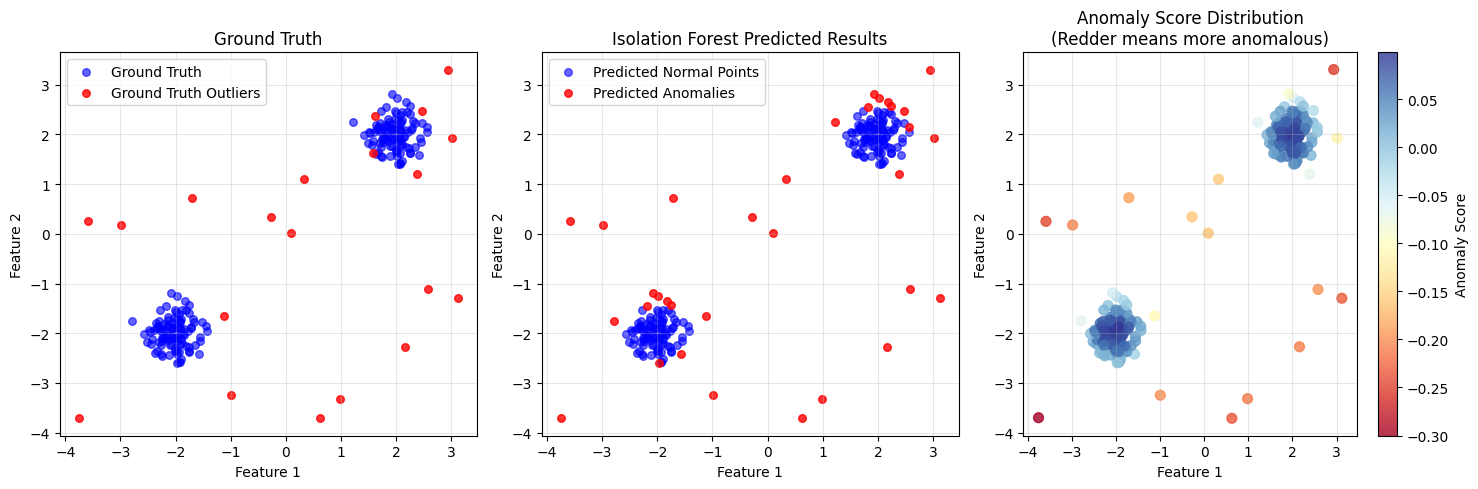

In [26]:
# 視覺化偵測結果
plt.figure(figsize=(15, 5))

# 子圖1：原始標記
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c='blue', s=30, alpha=0.6, label='Ground Truth')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', s=30, alpha=0.8, label='Ground Truth Outliers')
plt.title('Ground Truth')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# 子圖2：模型預測結果
plt.subplot(1, 3, 2)
plt.scatter(X_full[normal_mask, 0], X_full[normal_mask, 1],
           c='blue', s=30, alpha=0.6, label='Predicted Normal Points')
plt.scatter(X_full[anomaly_mask, 0], X_full[anomaly_mask, 1],
           c='red', s=30, alpha=0.8, label='Predicted Anomalies')
plt.title('Isolation Forest Predicted Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# 子圖3：異常分數熱圖
plt.subplot(1, 3, 3)
scatter = plt.scatter(X_full[:, 0], X_full[:, 1],
                     c=anomaly_scores, s=50, alpha=0.8, cmap='RdYlBu')
plt.colorbar(scatter, label='Anomaly Score')
plt.title('Anomaly Score Distribution\n(Redder means more anomalous)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 重要參數詳解

在使用 scikit-learn 的 IsolationForest 前，了解關鍵參數非常重要：

### 4.1 核心參數

**`n_estimators`** (預設: 100)
- **含義**：森林中樹的數量
- **建議**：100 通常已足夠，更多樹會提高穩定性但增加計算時間
- **範例**：`n_estimators=100`

**`max_samples`** (預設: 'auto')
- **含義**：訓練每棵樹使用的樣本數量
- **選項**：
  - `'auto'`：min(256, n_samples)
  - `int`：使用指定數量的樣本
  - `float`：使用總樣本的比例
- **重要性**：太大會增加計算成本，太小可能影響效果

**`contamination`** (預設: 'auto')
- **含義**：數據集中異常樣本的比例
- **作用**：決定異常判定的閾值
- **範例**：`contamination=0.1` 表示 10% 的數據是異常

### 4.2 進階參數

**`max_features`** (預設: 1.0)
- **含義**：每棵樹使用的特徵數量
- **選項**：
  - `int`：使用指定數量的特徵
  - `float`：使用總特徵的比例
- **建議**：對高維數據可考慮減少特徵數

**`n_jobs`** (預設: None)
- **含義**：並行運算的 CPU 核心數
- **選項**：
  - `None`：使用單核心
  - `-1`：使用所有可用核心
- **建議**：在大數據集上使用多核心以加速

**`random_state`**
- **含義**：隨機種子，確保結果可重現
- **建議**：總是設置此參數以確保實驗可重現

### 4.3 參數調優建議

**初學者設置：**
```python
IsolationForest(
    n_estimators=100,
    max_samples='auto', 
    contamination=0.1,
    random_state=42
)
```

**高級設置（大數據集）：**
```python
IsolationForest(
    n_estimators=200,
    max_samples=256,
    contamination='auto',
    max_features=0.8,
    n_jobs=-1,  # 使用所有CPU核心
    random_state=42
)
```


## 5. 實際應用：詐欺資料集偵測

接下來我們將使用 `InsFraudDataset6.csv` 資料集，利用 Isolation Forest 進行詐欺偵測。

資料集包含多個保險相關特徵，目標是找出潛在異常（詐欺）案件。

### 5.1 數據加載與探索

In [27]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 讀取詐欺資料集
data = pd.read_csv('text-book/InsFraudDataset6.csv')

print("=== 數據集基本信息 ===")
print(f"數據形狀: {data.shape}")
print(f"特徵數量: {data.shape[1]}")
print(f"樣本數量: {data.shape[0]}")

print("\n=== 數據前5行 ===")
print(data.head())

=== 數據集基本信息 ===
數據形狀: (1000, 8)
特徵數量: 8
樣本數量: 1000

=== 數據前5行 ===
   Severity   Age  policy_annual_premium  total_claim_amount  policy_number  \
0         3  22.0                1406.91               71610         521585   
1         1  38.0                1197.22                5070         342868   
2         3  26.0                1413.14               34650         687698   
3         1  35.0                1415.74               63400         227811   
4         3  35.0                1583.91                6500         367455   

   injury_claim  property_claim  vehicle_claim  
0          6510           13020          52080  
1           780             780           3510  
2          7700            3850          23100  
3          6340            6340          50720  
4          1300             650           4550  


以上欄位在保險風險統計中通常代表以下意義：

* **`Severity`**：理賠案件的嚴重程度，數值越高代表損失或風險越大，常用於風險分級或理賠金額預估。
* **`Age`**：被保險人的年齡，年齡會影響保費計算及風險評估（如年輕駕駛或高齡者風險較高）。
* **`policy_annual_premium`**：保單年度保費，代表客戶每年需支付的保險費用，與保障範圍及風險等級相關。
* **`total_claim_amount`**：理賠總金額，表示該保單或案件的累積理賠金額，反映損失規模。
* **`policy_number`**：保單編號，唯一識別每一份保單，便於資料管理與查詢。
* **`injury_claim`**：人身傷害理賠金額，針對因事故造成的人身傷害所申請的理賠。
* **`property_claim`**：財產損失理賠金額，針對財物損失（如車輛、房屋等）所申請的理賠。
* **`vehicle_claim`**：車輛損失理賠金額，專指車輛相關的損失理賠，常見於汽車保險。

這些欄位有助於保險公司進行風險分析、保費定價、理賠審核及詐欺偵測。

In [28]:
print("\n=== 缺失值檢查 ===")
missing_values = data.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("無缺失值")

print("\n=== 數據類型 ===")
print(data.dtypes)


=== 缺失值檢查 ===
無缺失值

=== 數據類型 ===
Severity                   int64
Age                      float64
policy_annual_premium    float64
total_claim_amount         int64
policy_number              int64
injury_claim               int64
property_claim             int64
vehicle_claim              int64
dtype: object


In [29]:
print("\n=== 數據統計摘要 ===")
print(data.describe())


=== 數據統計摘要 ===
          Severity          Age  policy_annual_premium  total_claim_amount  \
count  1000.000000  1000.000000            1000.000000          1000.00000   
mean      2.310000    29.283920            1256.406150         52761.94000   
std       0.832221    14.064937             244.167395         26401.53319   
min       1.000000     0.420000             433.330000           100.00000   
25%       2.000000    20.000000            1089.607500         41812.50000   
50%       3.000000    28.000000            1257.200000         58055.00000   
75%       3.000000    38.000000            1415.695000         70592.50000   
max       3.000000    80.000000            2047.590000        114920.00000   

       policy_number  injury_claim  property_claim  vehicle_claim  
count    1000.000000   1000.000000     1000.000000    1000.000000  
mean   546238.648000   7433.420000     7399.570000   37928.950000  
std    257063.005276   4880.951853     4824.726179   18886.252893  
min    10

### 5.2 數據預處理與模型訓練

Isolation Forest 不一定需要特徵標準化，但建議進行標準化，尤其是當各特徵的數值尺度差異很大時。

原因如下：

* Isolation Forest 隨機選擇分割點，若某些特徵數值範圍遠大於其他特徵，模型會偏向在這些特徵上分割，影響異常偵測效果。
* 標準化（如 StandardScaler）可讓所有特徵在相同尺度，有助於模型公平分割各維度，提高偵測準確度。

結論：

* 特徵尺度差異大時，Isolation Forest 建議先標準化特徵。
* 若所有特徵本身已在相近範圍，可不標準化。

In [30]:
# 數據預處理
# StandardScaler 它是將資料轉換為平均值為 0、標準差為 1 的分布（Z-score 標準化）。
scaler = StandardScaler()
# 如果你要把數值縮放到 0 到 1 區間，請使用 MinMaxScaler：
# scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

print("=== 標準化前後比較 ===")
print("原始數據範圍:")
for i, col in enumerate(data.columns):
    print(f"{col}: [{data[col].min():.2f}, {data[col].max():.2f}]")

print("\n標準化後數據範圍:")
for i, col in enumerate(data.columns):
    print(f"{col}: [{data_scaled[:, i].min():.2f}, {data_scaled[:, i].max():.2f}]")


=== 標準化前後比較 ===
原始數據範圍:
Severity: [1.00, 3.00]
Age: [0.42, 80.00]
policy_annual_premium: [433.33, 2047.59]
total_claim_amount: [100.00, 114920.00]
policy_number: [100804.00, 999435.00]
injury_claim: [0.00, 21450.00]
property_claim: [0.00, 23670.00]
vehicle_claim: [70.00, 79560.00]

標準化後數據範圍:
Severity: [-1.57, 0.83]
Age: [-2.05, 3.61]
policy_annual_premium: [-3.37, 3.24]
total_claim_amount: [-2.00, 2.36]
policy_number: [-1.73, 1.76]
injury_claim: [-1.52, 2.87]
property_claim: [-1.53, 3.37]
vehicle_claim: [-2.01, 2.21]


In [31]:
# 建立不同參數設置的 Isolation Forest 模型進行比較
models = {
    'conservative': IsolationForest(contamination=0.05, n_estimators=100, random_state=42), # 較保守設置, 5%
    'moderate': IsolationForest(contamination=0.1, n_estimators=100, random_state=42), # 中等設置, 10%
    'aggressive': IsolationForest(contamination=0.25, n_estimators=100, random_state=42) # 較激進設置, 25%
}

results = {}

for name, model in models.items():
    print(f"\n=== 訓練 {name} 模型 ===")

    # 訓練模型
    model.fit(data_scaled)

    # 預測
    predictions = model.predict(data_scaled)
    anomaly_scores = model.decision_function(data_scaled)

    # 統計結果
    n_anomalies = np.sum(predictions == -1)
    anomaly_rate = n_anomalies / len(data)

    results[name] = {
        'model': model,
        'predictions': predictions,
        'anomaly_scores': anomaly_scores,
        'n_anomalies': n_anomalies,
        'anomaly_rate': anomaly_rate
    }

    print(f"偵測到異常數量: {n_anomalies}")
    print(f"異常比例: {anomaly_rate:.2%}")
    print(f"異常分數範圍: [{anomaly_scores.min():.3f}, {anomaly_scores.max():.3f}]")



=== 訓練 conservative 模型 ===
偵測到異常數量: 50
異常比例: 5.00%
異常分數範圍: [-0.097, 0.158]

=== 訓練 moderate 模型 ===
偵測到異常數量: 100
異常比例: 10.00%
異常分數範圍: [-0.119, 0.136]

=== 訓練 aggressive 模型 ===
偵測到異常數量: 250
異常比例: 25.00%
異常分數範圍: [-0.149, 0.106]


In [32]:
# 選擇中等設置作為主要結果
main_model = models['moderate']
y_pred = results['moderate']['predictions']
anomaly_scores = results['moderate']['anomaly_scores']

# 將結果加入原始 DataFrame
df = data.copy()
df['Anomaly_Score'] = anomaly_scores
df['Prediction'] = y_pred
df['Is_Anomaly'] = (y_pred == -1)

print(f"\n=== 最終結果摘要 ===")
print(f"使用 moderate 設置 (contamination=0.1)")
print(f"異常樣本數: {np.sum(df['Is_Anomaly'])}")
print(f"異常比例: {np.sum(df['Is_Anomaly'])/len(df):.2%}")

# 顯示異常樣本示例
print("\n=== 異常樣本示例 ===")
anomaly_samples = df[df['Is_Anomaly']].head(10)
print(anomaly_samples[['Anomaly_Score'] + list(data.columns)])


=== 最終結果摘要 ===
使用 moderate 設置 (contamination=0.1)
異常樣本數: 100
異常比例: 10.00%

=== 異常樣本示例 ===
    Anomaly_Score  Severity   Age  policy_annual_premium  total_claim_amount  \
6       -0.003007         1  54.0                1333.35               78650   
11      -0.118760         1  58.0                1137.16              114920   
23      -0.049434         1  28.0                1268.79               98160   
27      -0.003473         1  19.0                 848.07                5720   
41      -0.017916         2  27.0                1737.66               97080   
57      -0.019454         2   5.0                1414.74                2400   
60      -0.039900         1  38.0                 795.23               69480   
63      -0.008434         1  64.0                1848.81               68520   
72      -0.000415         3  26.0                 895.83               30100   
91      -0.073904         1  46.0                1136.83               98340   

    policy_number  injury_cl

### 5.3 結果視覺化與分析

讓我們深入分析偵測結果，包括異常分數分布和特徵重要性：

/var/folders/j8/hkxkfjqd58j9t_718vfr4tjw0000gn/T/ipykernel_64998/1193287840.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(box_data, labels=['Anomalous Points', 'Normal Points'])


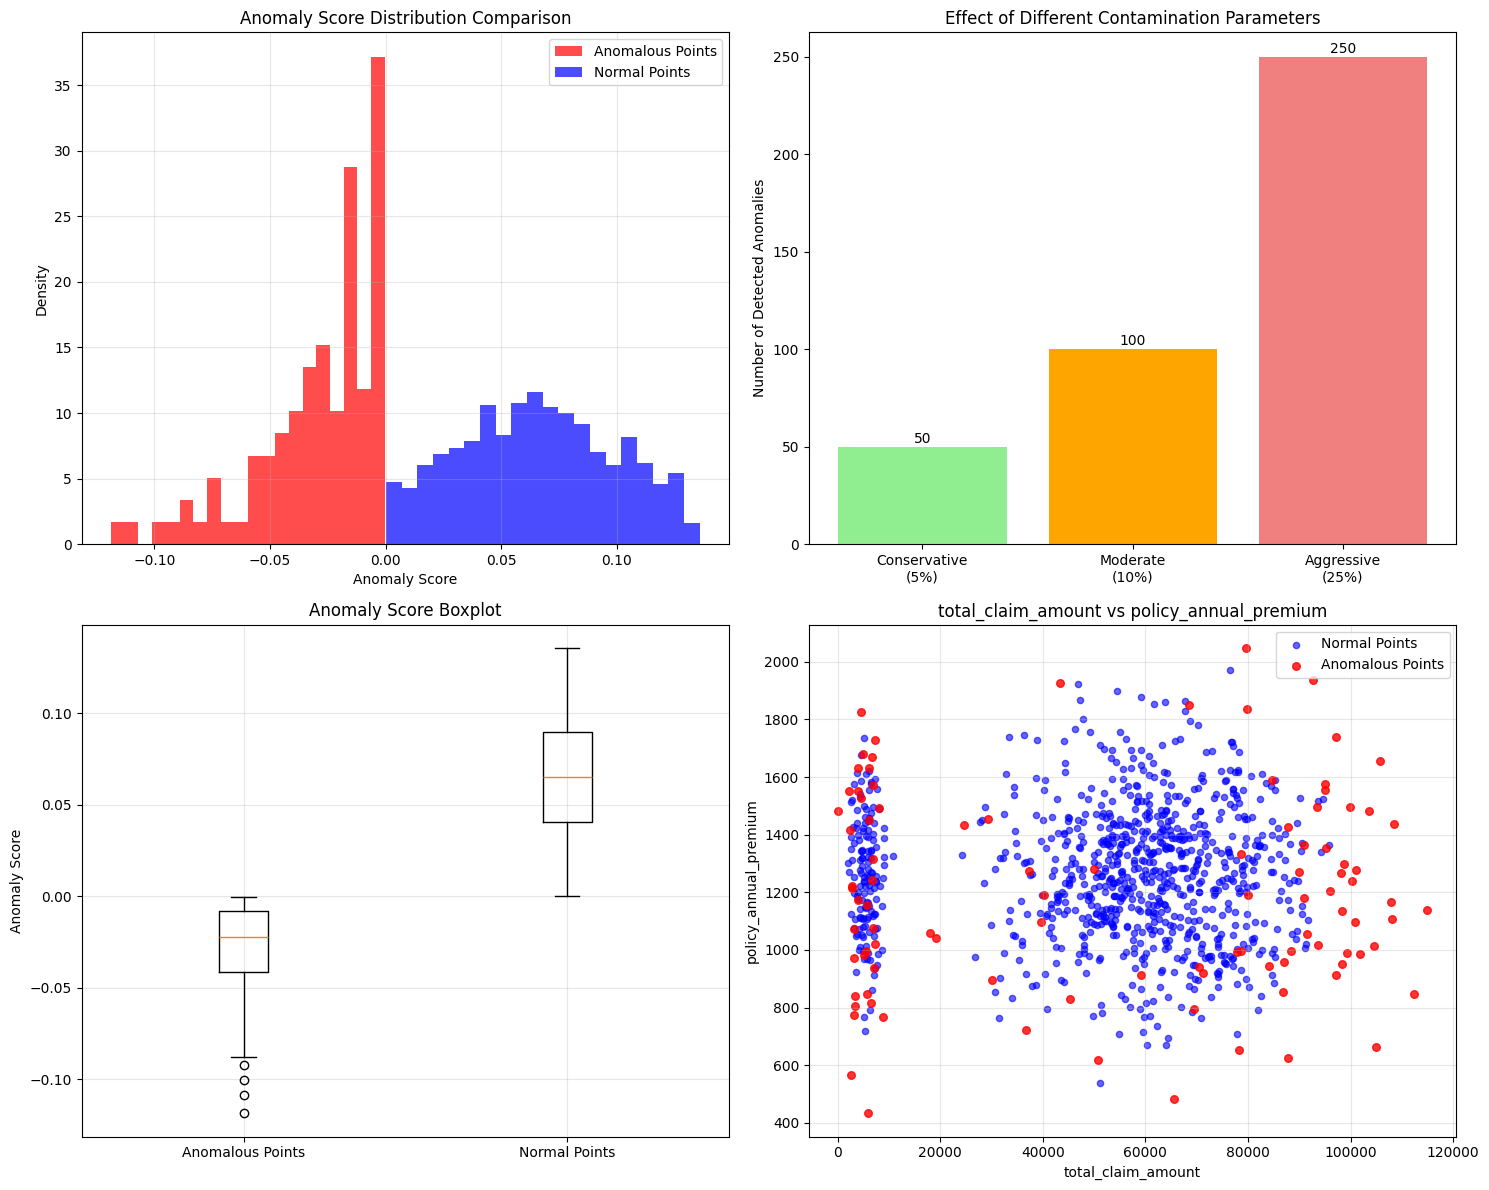

In [33]:
# 創建綜合視覺化分析
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 異常分數分布比較
axes[0, 0].hist(df[df['Is_Anomaly']]['Anomaly_Score'], bins=20, alpha=0.7,
               label='Anomalous Points', color='red', density=True)
axes[0, 0].hist(df[~df['Is_Anomaly']]['Anomaly_Score'], bins=20, alpha=0.7,
               label='Normal Points', color='blue', density=True)
axes[0, 0].set_title('Anomaly Score Distribution Comparison')
axes[0, 0].set_xlabel('Anomaly Score')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 不同contamination參數的比較
contamination_values = [0.05, 0.1, 0.25]
anomaly_counts = [results['conservative']['n_anomalies'],
                 results['moderate']['n_anomalies'],
                 results['aggressive']['n_anomalies']]

axes[0, 1].bar(['Conservative\n(5%)', 'Moderate\n(10%)', 'Aggressive\n(25%)'],
              anomaly_counts, color=['lightgreen', 'orange', 'lightcoral'])
axes[0, 1].set_title('Effect of Different Contamination Parameters')
axes[0, 1].set_ylabel('Number of Detected Anomalies')
for i, v in enumerate(anomaly_counts):
    axes[0, 1].text(i, v + 0.5, str(v), ha='center', va='bottom')

# 3. 異常分數箱型圖
box_data = [df[df['Is_Anomaly']]['Anomaly_Score'],
           df[~df['Is_Anomaly']]['Anomaly_Score']]
axes[1, 0].boxplot(box_data, labels=['Anomalous Points', 'Normal Points'])
axes[1, 0].set_title('Anomaly Score Boxplot')
axes[1, 0].set_ylabel('Anomaly Score')
axes[1, 0].grid(True, alpha=0.3)

# 4. 特徵值分布比較（以兩個特徵為例）
if data.shape[1] >= 2:
    # 分別為 total_claim_amount 和 policy_annual_premium
    feature1, feature2 = data.columns[3], data.columns[2]

    # 正常點
    normal_data = df[~df['Is_Anomaly']]
    axes[1, 1].scatter(normal_data[feature1], normal_data[feature2],
                      c='blue', alpha=0.6, s=20, label='Normal Points')

    # 異常點
    anomaly_data = df[df['Is_Anomaly']]
    axes[1, 1].scatter(anomaly_data[feature1], anomaly_data[feature2],
                      c='red', alpha=0.8, s=30, label='Anomalous Points')

    axes[1, 1].set_title(f'{feature1} vs {feature2}')
    axes[1, 1].set_xlabel(feature1)
    axes[1, 1].set_ylabel(feature2)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Boxplot（箱型圖）顯示資料分布

Boxplot（箱型圖）是一種用來顯示資料分布的圖表。它可以快速看出資料的中位數、範圍、分布狀況和是否有離群值。

簡單解釋如下：

* 中間的線：代表中位數（資料排序後的中間值）
* 箱子上下邊：分別是第1四分位數（Q1，25%）和第3四分位數（Q3，75%）
* 箱子的高度：顯示資料的主要分布範圍（Q1到Q3）
* 箱子外的「鬍鬚」：代表資料的最大值和最小值（但不包含離群值）
* 箱子外的點：就是離群值（outliers），表示明顯偏離大多數資料的數值

In [34]:
# 輸出統計摘要
print("=== 詳細統計分析 ===")
print(f"總樣本數: {len(df)}")
print(f"正常點數量: {len(df[~df['Is_Anomaly']])}")
print(f"異常點數量: {len(df[df['Is_Anomaly']])}")
print(f"異常比例: {len(df[df['Is_Anomaly']])/len(df):.2%}")

print(f"\n異常分數統計:")
print(f"整體範圍: [{df['Anomaly_Score'].min():.3f}, {df['Anomaly_Score'].max():.3f}]")
print(f"正常點平均分數: {df[~df['Is_Anomaly']]['Anomaly_Score'].mean():.3f}")
print(f"異常點平均分數: {df[df['Is_Anomaly']]['Anomaly_Score'].mean():.3f}")

# 顯示最異常的前5個樣本
print(f"\n=== 最異常的 5 個樣本 ===")
most_anomalous = df.nsmallest(5, 'Anomaly_Score')
print(most_anomalous[['Anomaly_Score'] + list(data.columns)])

=== 詳細統計分析 ===
總樣本數: 1000
正常點數量: 900
異常點數量: 100
異常比例: 10.00%

異常分數統計:
整體範圍: [-0.119, 0.136]
正常點平均分數: 0.066
異常點平均分數: -0.029

=== 最異常的 5 個樣本 ===
     Anomaly_Score  Severity   Age  policy_annual_premium  total_claim_amount  \
11       -0.118760         1  58.0                1137.16              114920   
149      -0.108843         2  51.0                 847.03              112320   
163      -0.100328         3   1.0                1166.54              107900   
996      -0.092417         3  47.0                1436.79              108480   
164      -0.087889         3   9.0                1495.06               99990   

     policy_number  injury_claim  property_claim  vehicle_claim  
11          214618         17680           17680          79560  
149         217938         17280           17280          77760  
163         346940         10790           21580          75530  
996         186934         18080           18080          72320  
164         985436         18180        

## 6. SHAP 解釋 Isolation Forest 模型

為了更好地理解模型如何判斷異常，我們使用 SHAP（SHapley Additive exPlanations）進行解釋。
SHAP 能夠告訴我們哪些特徵對於某筆資料被判定為異常有最大影響。

### 6.1 SHAP 基本概念

**SHAP 的優勢：**
- 提供特徵重要性的量化指標
- 解釋個別樣本的預測結果
- 符合博弈論 (Game Theory) 的公平性原則

**解讀方式：**
- 正值：該特徵促使樣本更可能被判定為異常
- 負值：該特徵促使樣本更可能被判定為正常
- 絕對值越大：該特徵的影響越重要

In [35]:
import shap

# 準備 SHAP 解釋器
# 注意：對於大數據集，我們使用樣本進行 SHAP 分析以提高效率
sample_size = min(100, len(data_scaled))
sample_indices = np.random.choice(len(data_scaled), sample_size, replace=False)
data_sample = data_scaled[sample_indices]

print(f"使用 {sample_size} 個樣本進行 SHAP 分析")

# 建立 SHAP explainer
# 使用 decision_function 而非 predict 來獲得連續的異常分數
explainer = shap.Explainer(main_model.decision_function, data_sample)
shap_values = explainer(data_sample)

print("SHAP 分析完成!")


使用 100 個樣本進行 SHAP 分析
SHAP 分析完成!


#### 繪製 SHAP value 瀑布圖

* 每個橫條代表一個特徵對該樣本預測結果的貢獻。
* 從上到下，依序加總每個特徵的SHAP值，最終得到模型對這筆資料的預測分數（如異常分數）。
* 紅色橫條：讓預測分數「往異常方向」推高（正向貢獻）。
* 藍色橫條：讓預測分數「往正常方向」降低（負向貢獻）。
* 橫條越長，代表該特徵影響越大。
* 最底部的數值，就是模型對這筆資料的最終預測分數。

樣本中發現 12 個異常點
分析第 1 個樣本的 SHAP 值


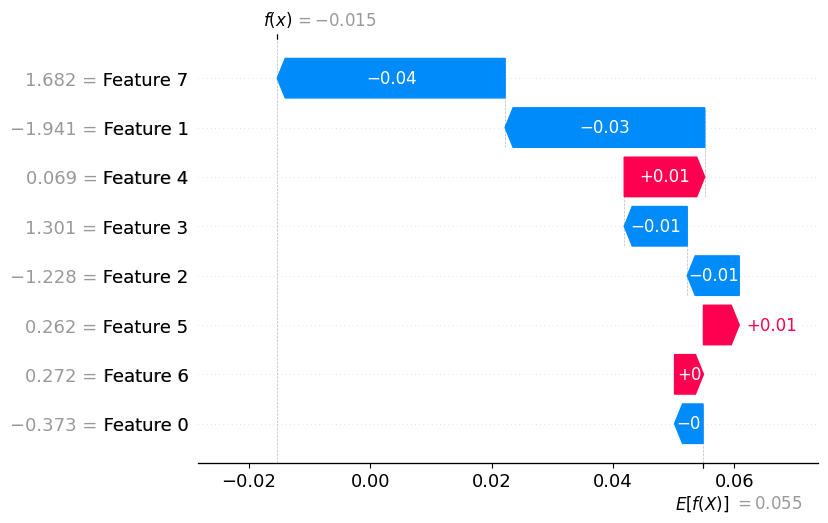

In [36]:
# 找出異常樣本在樣本中的索引
anomaly_indices_in_sample = []
sample_predictions = main_model.predict(data_sample)
for i, pred in enumerate(sample_predictions):
    if pred == -1:
        anomaly_indices_in_sample.append(i)

if len(anomaly_indices_in_sample) > 0:
    print(f"樣本中發現 {len(anomaly_indices_in_sample)} 個異常點")

    # 視覺化第一個異常樣本的 SHAP 值
    first_anomaly_idx = anomaly_indices_in_sample[0]
    print(f"分析第 {first_anomaly_idx} 個樣本的 SHAP 值")

    # 瀑布圖 - 顯示單個預測的特徵貢獻
    shap.plots.waterfall(shap_values[first_anomaly_idx], max_display=10)

else:
    print("樣本中沒有發現異常點，使用異常分數最低的樣本進行分析")
    min_score_idx = np.argmin(explainer(data_sample).values.sum(axis=1))
    shap.plots.waterfall(shap_values[min_score_idx], max_display=10)

### 6.2 全局特徵重要性分析

#### 特徵重要性總結圖

特徵重要性總結圖（SHAP bar plot）的解讀方式如下：

* 每個橫條代表一個特徵的平均**絕對SHAP值**，表示該特徵對模型預測的影響力大小。
* 橫條越長，代表該特徵對異常偵測結果的貢獻越大。
* 排名越前的特徵，越值得關注，因為它們最能影響模型判斷異常或正常。
* 此圖有助於快速了解「哪些特徵」是模型判斷的關鍵依據，方便後續特徵選擇或業務解釋。

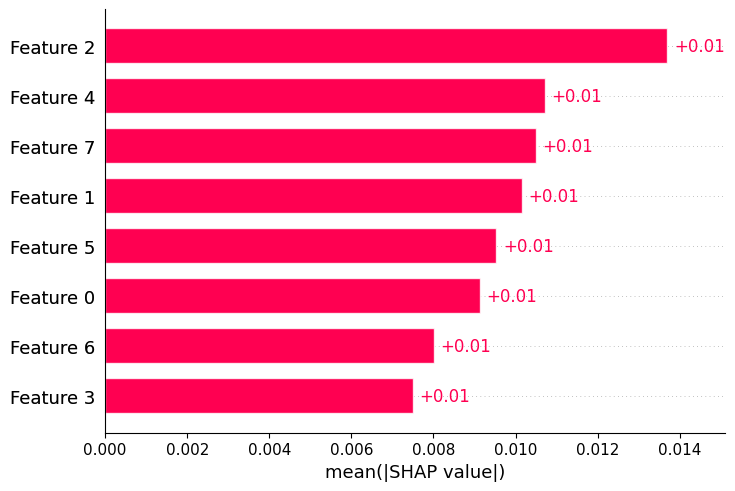

In [37]:
# 1. 特徵重要性總結圖
shap.plots.bar(shap_values, max_display=10)


#### 蜂群圖

蜂群圖（SHAP beeswarm plot）解讀方式如下：

* 每個點代表一個樣本在某個特徵上的 SHAP 值。
* 橫軸：SHAP值，表示該特徵對預測結果的貢獻方向與大小（正值推向異常，負值推向正常）。
* 縱軸：特徵名稱，從上到下依據平均重要性排序。
* 點的顏色：代表該樣本在此特徵上的原始值（通常紅色高、藍色低）。
* 點分布越寬，表示該特徵對不同樣本的影響變化大。
* 可同時看出特徵重要性、貢獻方向，以及特徵值與模型判斷的關係。

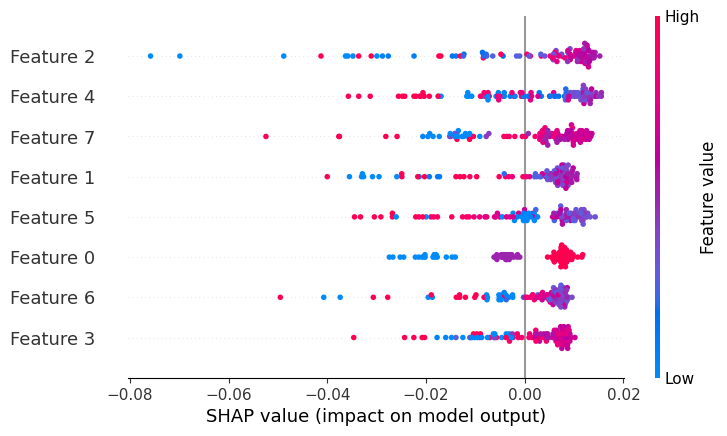

In [38]:
# 2. 蜂群圖 - 顯示特徵值與SHAP值的關係
shap.plots.beeswarm(shap_values, max_display=10)


In [39]:
# 3. 計算並顯示特徵重要性排名
feature_importance = np.abs(shap_values.values).mean(axis=0)
feature_names = data.columns

# 創建特徵重要性 DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("=== 特徵重要性排名 ===")
print(importance_df)


=== 特徵重要性排名 ===
                 Feature  Importance
2  policy_annual_premium    0.013701
4          policy_number    0.010708
7          vehicle_claim    0.010492
1                    Age    0.010154
5           injury_claim    0.009535
0               Severity    0.009122
6         property_claim    0.008012
3     total_claim_amount    0.007499


#### 相關性分析

相關性分析（如相關性熱圖）解讀方式如下：

* 熱圖展示各特徵之間的皮爾森相關係數（範圍 -1 到 1）。
* 顏色越接近紅色（正相關），表示兩特徵數值同時上升或下降。
* 顏色越接近藍色（負相關），表示一個特徵上升時另一個下降。
* 顏色越接近白色或中間色，表示兩特徵之間幾乎沒有線性關係。
* 熱圖有助於發現高度相關或冗餘的特徵，指引特徵選擇或降維。

/var/folders/j8/hkxkfjqd58j9t_718vfr4tjw0000gn/T/ipykernel_64998/1710533918.py:19: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j8/hkxkfjqd58j9t_718vfr4tjw0000gn/T/ipykernel_64998/1710533918.py:19: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j8/hkxkfjqd58j9t_718vfr4tjw0000gn/T/ipykernel_64998/1710533918.py:19: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j8/hkxkfjqd58j9t_718vfr4tjw0000gn/T/ipykernel_64998/1710533918.py:19: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j8/hkxkfjqd58j9t_718vfr4tjw0000gn/T/ipykernel_64998/1710533918.py:19: UserWarning: Glyph 38364 (\N{CJK UNIFIED IDEOGRAPH-95DC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j8/hkxk

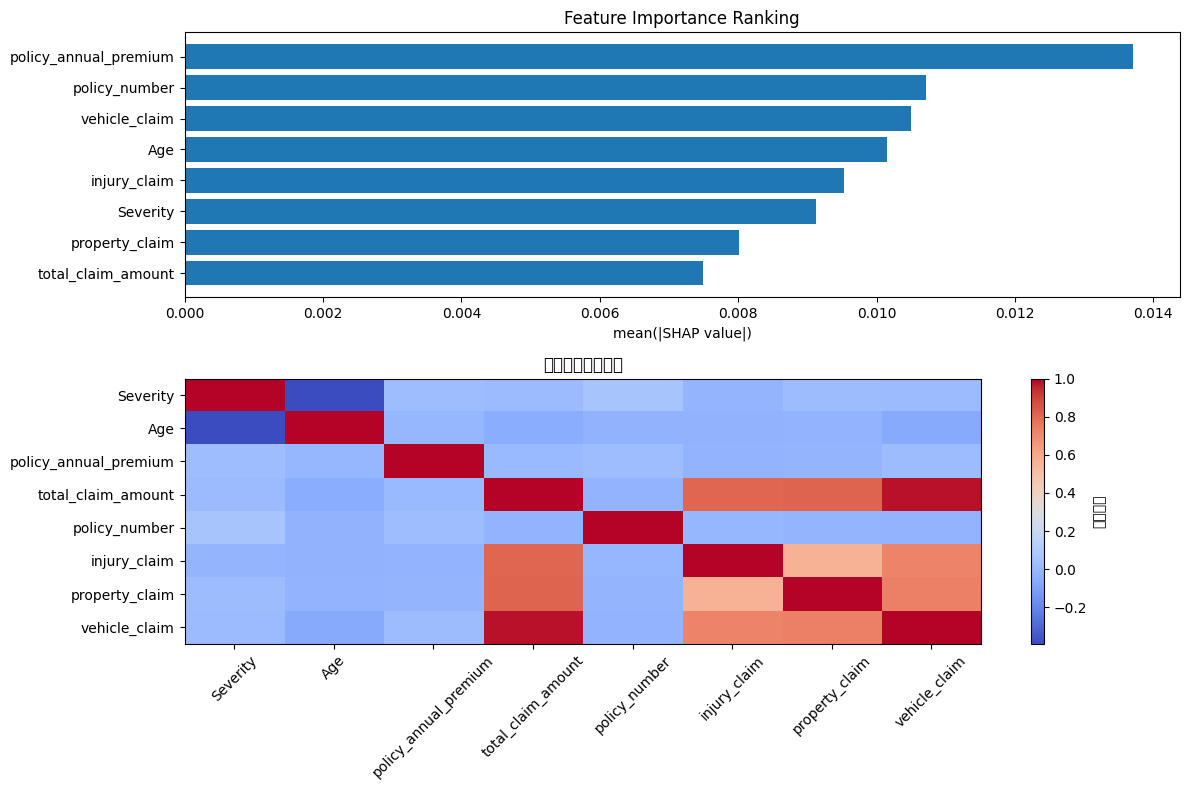

In [40]:
# 4. 自定義視覺化 (特徵重要性總結圖)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.barh(range(len(importance_df)), importance_df['Importance'])
plt.yticks(range(len(importance_df)), importance_df['Feature'])
plt.xlabel('mean(|SHAP value|)')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()

# 5. 相關性分析
plt.subplot(2, 1, 2)
correlation_matrix = data.corr()
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='相關係數')
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.yticks(range(len(feature_names)), feature_names)
plt.title('特徵間相關性熱圖')

plt.tight_layout()
plt.show()

## 7. 總結與延伸閱讀

### 7.1 Isolation Forest 總結

**主要優勢：**
- ✅ **線性時間複雜度**：適合大數據集
- ✅ **無監督學習**：不需要標記數據
- ✅ **可並行化**：每棵樹獨立構建
- ✅ **內存效率高**：只需要少量樣本

**主要限制：**
- ❌ **高維度問題**：隨機選擇特徵可能忽略重要維度
- ❌ **局部異常**：主要檢測全局異常，對局部異常不敏感
- ❌ **異常比例敏感**：如果異常比例過高會影響效果

**適用場景：**
- 金融詐欺偵測
- 網路安全入侵偵測  
- 工業設備異常監控
- 數據品質檢查

### 7.2 延伸閱讀與進階主題

**原始論文與理論：**
- [Isolation Forest 原始論文](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf)
- [Extended Isolation Forest](https://arxiv.org/abs/1811.02141)

**實作相關：**
- [scikit-learn IsolationForest 官方文件](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)
- [SHAP 官方文件](https://shap.readthedocs.io/en/latest/)

**進階技術：**
- **Local Outlier Factor (LOF)**：適合局部異常偵測
- **One-Class SVM**：適合小數據集和高維數據
- **Autoencoder**：深度學習方法，適合複雜模式

**實務應用案例：**
- 信用卡詐欺偵測實戰
- 工業IoT異常監控系統
- 網路流量異常分析

---

### 練習建議

1. **嘗試不同參數**：調整 contamination、n_estimators 等參數觀察效果
2. **比較不同算法**：與 LOF、One-Class SVM 等算法比較
3. **使用真實數據**：將方法應用到你的業務數據上
4. **結合領域知識**：利用 SHAP 解釋結果，結合專業知識進行驗證

記住：異常偵測沒有標準答案，關鍵是要結合業務需求和領域專業知識！

## 8. 簡單範例：toy data 無異常點

本章節展示在完全沒有異常點的 toy data 下，Isolation Forest 計算出的 anomaly_scores 熱圖。這有助於理解模型在正常數據下的表現，以及分數分布的特性。

正常數據點數量: 200
異常數據點數量: 0
總數據點數量: 200
實際異常比例: 0.00%


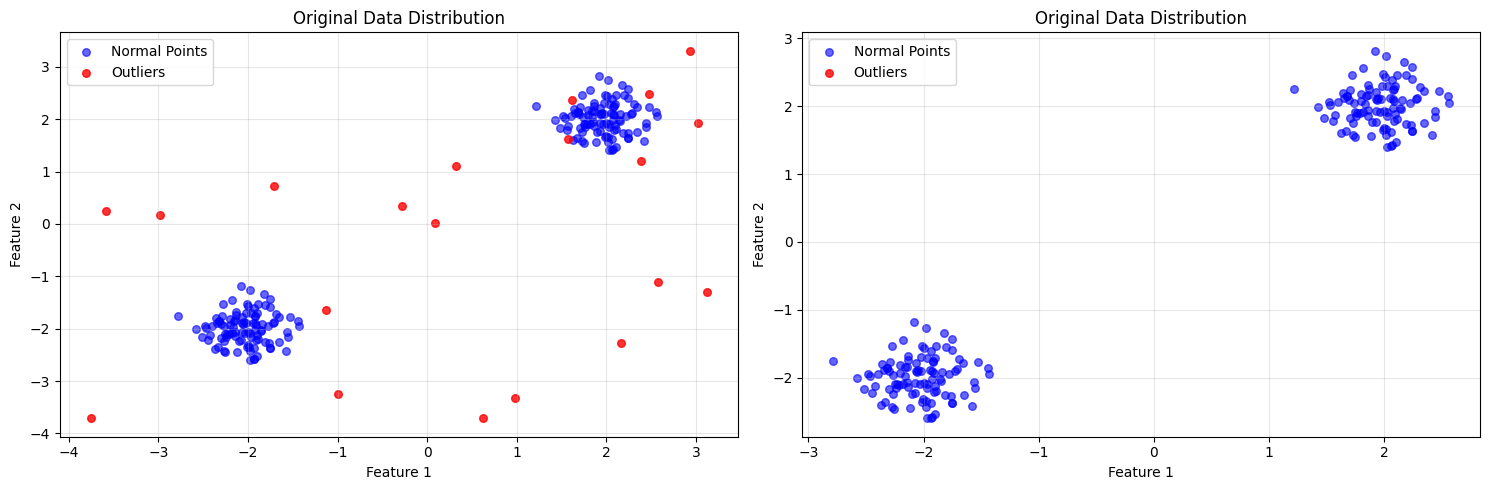

In [41]:
# 利用先前產生的 X_normal 產生無異常點的 toy data

# 視覺化原始數據
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c='blue', s=30, alpha=0.6, label='Normal Points')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', s=30, alpha=0.8, label='Outliers')
plt.title("Original Data Distribution")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)

# 生成正常數據點
# 清空先前 X_outliers
X_outliers = np.empty((0, 2))

# 合併所有數據
X_full_normal = np.r_[X, X_outliers]

print(f"正常數據點數量: {len(X)}")
print(f"異常數據點數量: {len(X_outliers)}")
print(f"總數據點數量: {len(X_full_normal)}")
print(f"實際異常比例: {len(X_outliers)/len(X_full_normal):.2%}")

# 視覺化原始數據
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c='blue', s=30, alpha=0.6, label='Normal Points')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', s=30, alpha=0.8, label='Outliers')
plt.title("Original Data Distribution")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [42]:
# 建立 Isolation Forest 模型
clf = IsolationForest(
    contamination=0.15,  # 預期15%的數據是異常（接近實際的10%）
    n_estimators=100,    # 使用100棵樹
    max_samples='auto',  # 自動決定樣本數（min(256, n_samples)）
    random_state=42      # 確保結果可重現
)

clf_normal = IsolationForest(
    contamination=0.15,  # 預期15%的數據是異常（接近實際的10%）
    n_estimators=100,    # 使用100棵樹
    max_samples='auto',  # 自動決定樣本數（min(256, n_samples)）
    random_state=42      # 確保結果可重現
)

# 訓練模型並預測
clf.fit(X_full)
y_pred = clf.predict(X_full)  # 1表示正常點，-1表示異常點
anomaly_scores = clf.decision_function(X_full)  # 異常分數

clf_normal.fit(X_full_normal)
y_pred_normal = clf_normal.predict(X_full_normal)  # 1表示正常點，-1表示異常點
anomaly_scores_normal = clf_normal.decision_function(X_full_normal)  # 異常分數

# 計算偵測結果統計
normal_mask = (y_pred_normal == 1)
anomaly_mask = (y_pred_normal == -1)

print("=== 偵測結果統計 ===")
print(f"偵測到正常點: {np.sum(normal_mask)} 個")
print(f"偵測到異常點: {np.sum(anomaly_mask)} 個")
print(f"偵測異常比例: {np.sum(anomaly_mask)/len(X_full):.2%}")

=== 偵測結果統計 ===
偵測到正常點: 170 個
偵測到異常點: 30 個
偵測異常比例: 13.64%


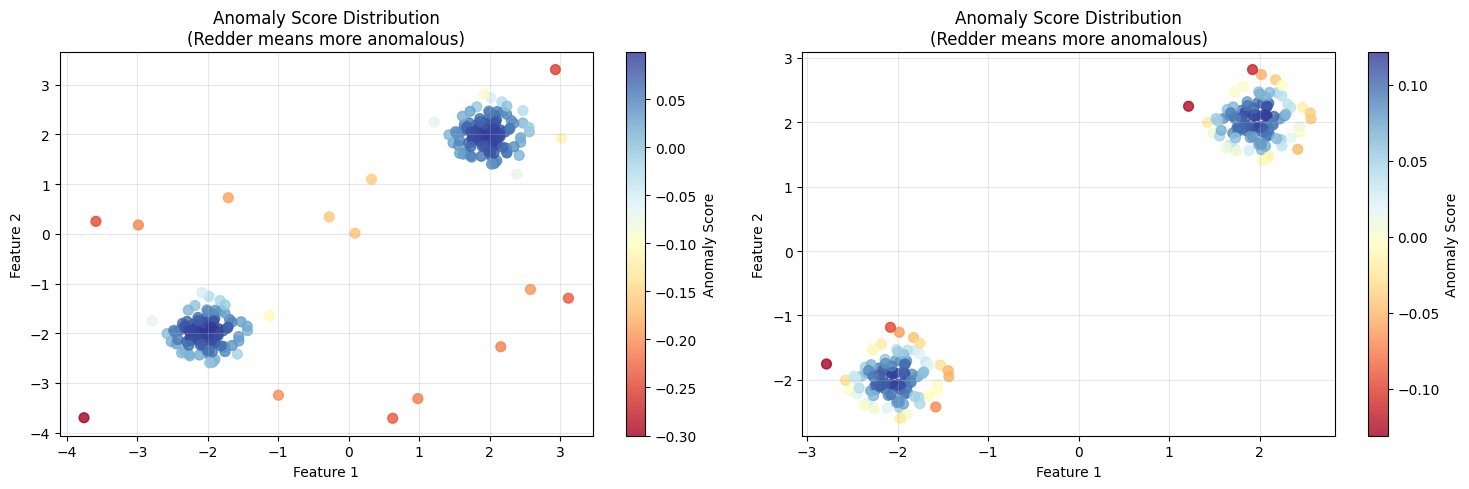

In [43]:
# 視覺化偵測結果
plt.figure(figsize=(15, 5))

# 子圖1：異常分數熱圖 (X_full)
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_full[:, 0], X_full[:, 1],
                     c=anomaly_scores, s=50, alpha=0.8, cmap='RdYlBu')
plt.colorbar(scatter, label='Anomaly Score')
plt.title('Anomaly Score Distribution\n(Redder means more anomalous)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

# 子圖2：異常分數熱圖 (X_full_normal)
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_full_normal[:, 0], X_full_normal[:, 1],
                     c=anomaly_scores_normal, s=50, alpha=0.8, cmap='RdYlBu')
plt.colorbar(scatter, label='Anomaly Score')
plt.title('Anomaly Score Distribution\n(Redder means more anomalous)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

在完全沒有異常點的 toy data 下，Isolation Forest 的 anomaly_scores 分布較為均勻，顯示模型無法明顯區分異常點。這說明在純正常數據下，anomaly score 主要反映資料分布的微小差異，而非異常偵測。